Kształt tensora X_train: (4000, 33, 2)
Kształt tensora T_train: (4000, 33, 1)
Rozpoczynanie treningu (to może chwilę potrwać)...
Epoka 1/10
Strata na końcu epoki: 0.219791
Epoka 2/10
Strata na końcu epoki: 0.189023
Epoka 3/10
Strata na końcu epoki: 0.167491
Epoka 4/10
Strata na końcu epoki: 0.164268
Epoka 5/10
Strata na końcu epoki: 0.163728
Epoka 6/10
Strata na końcu epoki: 0.162584
Epoka 7/10
Strata na końcu epoki: 0.162137
Epoka 8/10
Strata na końcu epoki: 0.162041
Epoka 9/10
Strata na końcu epoki: 0.161980
Epoka 10/10
Strata na końcu epoki: 0.161935

--- Testowanie na nowych danych (32-bit) ---
L1:   010011010110001110111011000000111 (2596763143)
L2: + 001000101101110111000110111011001 (1169919449)
Cel:  011100000100000110000001111100000 (3766682592)
Sieć: 011100000000000000000001111100000 (3758097376)
----------------------------------------
L1:   000101011011000000001110000110010 (727718962)
L2: + 000000001010001011010001100010001 (21340945)
Cel:  00010110010100101101111110100001

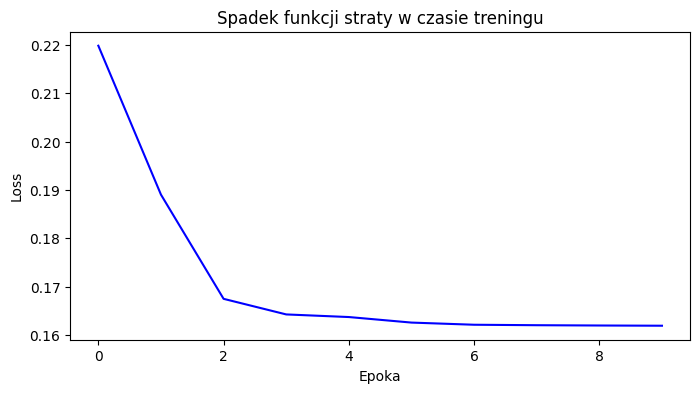

In [1]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt

# Konfiguracja wizualizacji
try:
    import seaborn as sns
    sns.set_style('darkgrid')
except ImportError:
    pass

# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(seed=1)
random.seed(1)

# 1. KONFIGURACJA DLA WARIANTU 32-BITOWEGO

# Liczba próbek treningowych
nb_train = 4000
# Długość sekwencji binarnej: 32 bity danych + 1 bit na potencjalne przeniesienie (overflow)
sequence_len = 33

# 2. PRZYGOTOWANIE DANYCH

def create_dataset(nb_samples, sequence_len):
    """
    Tworzy zbiór danych do dodawania binarnego.
    Zwraca wejścia (X) i cele (T).
    """
    # Maksymalna liczba całkowita, którą można dodać
    max_int = 2**(sequence_len - 1)
    
    format_str = '{:0' + str(sequence_len) + 'b}'
    nb_inputs = 2
    nb_outputs = 1

    X = np.zeros((nb_samples, sequence_len, nb_inputs))
    T = np.zeros((nb_samples, sequence_len, nb_outputs))

    for i in range(nb_samples):
        # Generowanie losowych liczb do dodania
        # Używamy random.randrange zamiast np.random.randint dla dużych liczb
        nb1 = random.randrange(0, max_int)
        nb2 = random.randrange(0, max_int)

        # Wypełnianie macierzy wejść i celów.
        # Odwracamy sekwencję (LSB first)
        X[i, :, 0] = list(reversed([int(b) for b in format_str.format(nb1)]))
        X[i, :, 1] = list(reversed([int(b) for b in format_str.format(nb2)]))
        T[i, :, 0] = list(reversed([int(b) for b in format_str.format(nb1 + nb2)]))

    return X, T

# Generowanie danych treningowych
X_train, T_train = create_dataset(nb_train, sequence_len)
print(f'Kształt tensora X_train: {X_train.shape}')
print(f'Kształt tensora T_train: {T_train.shape}')

# 3. ARCHITEKTURA SIECI

class TensorLinear(object):
    """Warstwa liniowa operująca na tensorach."""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        self.bpAxes = tuple(range(tensor_order - 1))

    def forward(self, X):
        return np.tensordot(X, self.W, axes=((-1), (0))) + self.b

    def backward(self, X, gY):
        gw = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        gX = np.tensordot(gY, self.W.T, axes=((-1), (0)))
        return gX, gw, gB

class LogisticClassifier(object):
    """Warstwa logistyczna (Sigmoid)."""
    def forward(self, X):
        return 1. / (1. + np.exp(-X))

    def backward(self, Y, T):
        # Uśrednianie przez liczbę próbek i długość sekwencji
        return (Y - T) / (Y.shape[0] * Y.shape[1])

    def loss(self, Y, T):
        return -np.mean((T * np.log(Y)) + ((1 - T) * np.log(1 - Y)))

class TanH(object):
    """Funkcja aktywacji TanH."""
    def forward(self, X):
        return np.tanh(X)

    def backward(self, Y, output_grad):
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)

class RecurrentStateUpdate(object):
    """Aktualizacja stanu wewnętrznego."""
    def __init__(self, nbStates, W, b):
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        return self.tanh.forward(Xk + self.linear.forward(Sk))

    def backward(self, Sk0, Sk1, output_grad):
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gw, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gw, gB

class RecurrentStateUnfold(object):
    """Rozwijanie stanów rekurencyjnych w czasie."""
    def __init__(self, nbStates, nbTimesteps):
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))
        self.S0 = np.zeros(nbStates)
        self.nbTimesteps = nbTimesteps
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)

    def forward(self, X):
        S = np.zeros((X.shape[0], X.shape[1] + 1, self.W.shape[0]))
        S[:, 0, :] = self.S0
        for k in range(self.nbTimesteps):
            S[:, k + 1, :] = self.stateUpdate.forward(X[:, k, :], S[:, k, :])
        return S

    def backward(self, X, S, gY):
        gSk = np.zeros_like(gY[:, self.nbTimesteps - 1, :])
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)
        gBSum = np.zeros_like(self.b)
        for k in range(self.nbTimesteps - 1, -1, -1):
            gSk += gY[:, k, :]
            gZ[:, k, :], gSk, gw, gB = self.stateUpdate.backward(S[:, k, :], S[:, k + 1, :], gSk)
            gWSum += gw
            gBSum += gB
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

class RnnBinaryAdder(object):
    """Pełna sieć RNN do dodawania binarnego."""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, sequence_len):
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifier()
        self.sequence_len = sequence_len

    def forward(self, X):
        recIn = self.tensorInput.forward(X)
        S = self.rnnUnfold.forward(recIn)
        Z = self.tensorOutput.forward(S[:, 1:self.sequence_len + 1, :])
        Y = self.classifier.forward(Z)
        return recIn, S, Z, Y

    def backward(self, X, Y, recIn, S, T):
        gZ = self.classifier.backward(Y, T)
        gRecOut, gWout, gBout = self.tensorOutput.backward(S[:, 1:self.sequence_len + 1, :], gZ)
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0

    def getOutput(self, X):
        recIn, S, Z, Y = self.forward(X)
        return Y

    def getBinaryOutput(self, X):
        return np.around(self.getOutput(X))

    def getParamGrads(self, X, T):
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(X, Y, recIn, S, T)
        return [g for g in itertools.chain(
            np.nditer(gS0), np.nditer(gWin), np.nditer(gBin),
            np.nditer(gWrec), np.nditer(gBrec),
            np.nditer(gWout), np.nditer(gBout))]

    def loss(self, Y, T):
        return self.classifier.loss(Y, T)

    def get_params_iter(self):
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

# 4. TRENING (RMSProp z Momentum Niestierowa)

# Hiperparametry
lmbd = 0.5          # Rmsprop lambda
learning_rate = 0.05
momentum_term = 0.80
eps = 1e-6
mb_size = 100       # Rozmiar minibatcha

# Tworzenie sieci
nb_of_states = 4    # Zwiększono liczbę stanów z 3 do 4 dla stabilności przy 32 bitach
RNN = RnnBinaryAdder(2, 1, nb_of_states, sequence_len)

# Inicjalizacja parametrów optymalizatora
nbParameters = sum(1 for _ in RNN.get_params_iter())
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]

ls_of_loss = []

print("Rozpoczynanie treningu (to może chwilę potrwać)...")
iterations = 10

for i in range(iterations):
    print(f"Epoka {i+1}/{iterations}")
    for mb in range(nb_train // mb_size):
        X_mb = X_train[mb:mb+mb_size, :, :]
        T_mb = T_train[mb:mb+mb_size, :, :]

        # Momentum Niestierowa - krok "w przód" pędu
        V_tmp = [v * momentum_term for v in Vs]
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]

        # Obliczenie gradientów
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)

        # Aktualizacja parametrów
        for pIdx, P in enumerate(RNN.get_params_iter()):
            # Aktualizacja średniej kwadratów (RMSProp)
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (1 - lmbd) * backprop_grads[pIdx]**2
            
            # Normalizacja gradientu
            pGradNorm = ((learning_rate * backprop_grads[pIdx]) / np.sqrt(maSquare[pIdx] + eps))
            
            # Aktualizacja pędu i parametru
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm
            P -= pGradNorm

    current_loss = RNN.loss(RNN.getOutput(X_mb), T_mb)
    ls_of_loss.append(current_loss)
    print(f"Strata na końcu epoki: {current_loss:.6f}")

# 5. TESTOWANIE

print("\n--- Testowanie na nowych danych (32-bit) ---")
nb_test = 5
X_test, T_test = create_dataset(nb_test, sequence_len)
Y_test = RNN.getBinaryOutput(X_test)

def printSample(x1, x2, t, y):
    """Pomocnicza funkcja do wyświetlania wyników"""
    x1_str = ''.join(str(int(d)) for d in reversed(x1)) # Odwracamy z powrotem do normalnego zapisu
    x2_str = ''.join(str(int(d)) for d in reversed(x2))
    t_str = ''.join(str(int(d[0])) for d in reversed(t))
    y_str = ''.join(str(int(d[0])) for d in reversed(y))
    
    print(f"L1:   {x1_str} ({int(x1_str, 2)})")
    print(f"L2: + {x2_str} ({int(x2_str, 2)})")
    print(f"Cel:  {t_str} ({int(t_str, 2)})")
    print(f"Sieć: {y_str} ({int(y_str, 2)})")
    print("-" * 40)

for i in range(nb_test):
    printSample(X_test[i,:,0], X_test[i,:,1], T_test[i,:,:], Y_test[i,:,:])

# Wykres straty
plt.figure(figsize=(8, 4))
plt.plot(ls_of_loss, 'b')
plt.title('Spadek funkcji straty w czasie treningu')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.show()